<a href="https://colab.research.google.com/github/sggyuan/GNN/blob/main/merged_label-added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/subset10w.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   User                         100000 non-null  int64  
 1   Card                         100000 non-null  int64  
 2   Year                         100000 non-null  int64  
 3   Month                        100000 non-null  int64  
 4   Day                          100000 non-null  int64  
 5   Time                         100000 non-null  object 
 6   Amount                       100000 non-null  object 
 7   Use Chip                     100000 non-null  object 
 8   Merchant Name                100000 non-null  int64  
 9   Merchant City                100000 non-null  object 
 10  Merchant State               88723 non-null   object 
 11  Zip                          88095 non-null   float64
 12  MCC                          100000 non-null  int64  
 13  

In [5]:
df [df['Is Fraud?'] == 'Yes'].shape

(117, 33)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Apartment'),
  Text(2, 0, 'Zip'),
  Text(3, 0, 'Merchant State'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Num Credit Cards'),
  Text(6, 0, 'Merchant Name'),
  Text(7, 0, 'MCC'),
  Text(8, 0, 'Merchant City'),
  Text(9, 0, 'Use Chip'),
  Text(10, 0, 'Person'),
  Text(11, 0, 'Amount'),
  Text(12, 0, 'Time'),
  Text(13, 0, 'Day'),
  Text(14, 0, 'Month'),
  Text(15, 0, 'Year'),
  Text(16, 0, 'User'),
  Text(17, 0, 'Total Debt'),
  Text(18, 0, 'Current Age'),
  Text(19, 0, 'FICO Score'),
  Text(20, 0, 'Retirement Age'),
  Text(21, 0, 'Birth Year'),
  Text(22, 0, 'Birth Month'),
  Text(23, 0, 'Gender'),
  Text(24, 0, 'Address'),
  Text(25, 0, 'City'),
  Text(26, 0, 'State'),
  Text(27, 0, 'Zipcode'),
  Text(28, 0, 'Latitude'),
  Text(29, 0, 'Longitude'),
  Text(30, 0, 'Pe

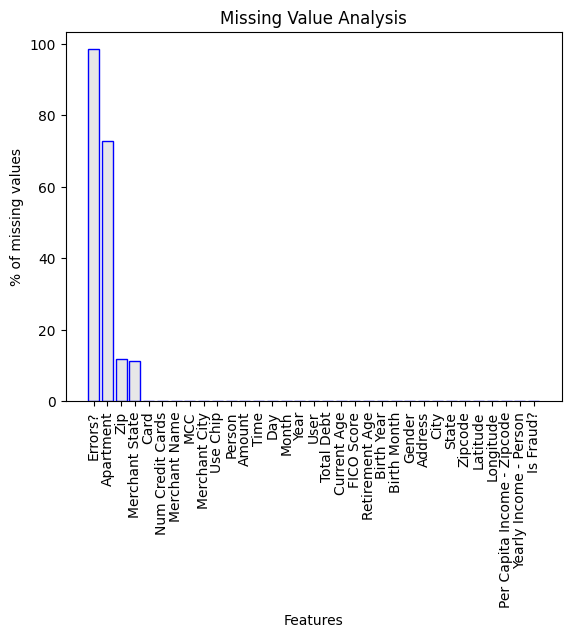

In [6]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [7]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [8]:
df.Amount.head(5)

,Amount
0,$86.89
1,$1.91
2,$13.82
3,$15.34
4,$14.82


In [9]:
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [10]:
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [11]:
df.Hour

,Hour
0,22
1,08
2,13
3,12
4,12
...,...
99995,07
99996,15
99997,12
99998,12


In [12]:
df.Minute

,Minute
0,18
1,30
2,54
3,20
4,39
...,...
99995,51
99996,45
99997,19
99998,34


In [13]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Year                         100000 non-null  int64  
 1   Month                        100000 non-null  int64  
 2   Day                          100000 non-null  int64  
 3   Amount                       100000 non-null  float64
 4   Use Chip                     100000 non-null  object 
 5   Merchant Name                100000 non-null  int64  
 6   Merchant City                100000 non-null  object 
 7   Merchant State               88723 non-null   object 
 8   Zip                          88095 non-null   float64
 9   MCC                          100000 non-null  int64  
 10  Errors?                      1630 non-null    object 
 11  Is Fraud?                    100000 non-null  object 
 12  Person                       100000 non-null  object 
 13  

In [14]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Bad Expiration,Insufficient Balance',
       'Bad PIN,Insufficient Balance',
       'Insufficient Balance,Technical Glitch'], dtype=object)

In [15]:

df["Errors?"]= df["Errors?"].fillna("No error")

In [16]:
df = df.drop(columns=["Merchant State","Zip","Apartment"],axis=1)

In [17]:
# change the is fraud column to binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [18]:
df['Per Capita Income - Zipcode'] = df['Per Capita Income - Zipcode'].str.replace('$', '').astype(float)
df['Yearly Income - Person'] = df['Yearly Income - Person'].str.replace('$', '').astype(float)
df['Total Debt'] = df['Total Debt'].str.replace('$', '').astype(float)


In [19]:
categorical_columns = ['Errors?' , 'Person', 'Address', 'City', 'Merchant City', 'MCC', 'card_id', 'State']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# label encode plus freq encode

le = LabelEncoder()
df['Merchant_Label'] = le.fit_transform(df['Merchant Name'])

merchant_frequencies = df['Merchant Name'].value_counts(normalize=True)
df['Merchant_Frequency'] = df['Merchant Name'].map(dict(merchant_frequencies))
print("sample after encoing：")
print(df[['Merchant Name', 'Merchant_Label', 'Merchant_Frequency']].head())

df = df.drop('Merchant Name', axis=1)

sample after encoing：
         Merchant Name  Merchant_Label  Merchant_Frequency
0 -5162038175624867091            2594             0.02753
1  6091778774361517457            9314             0.00243
2  2027553650310142703            6893             0.04191
3 -4317138273541964845            3174             0.00205
4 -5581123930363301609            2322             0.00323


In [21]:
df_encoded = pd.get_dummies(df, columns=['State'], prefix='State')

In [22]:
gender_encoded = pd.get_dummies(df['Gender'], prefix='Gender')


df = pd.concat([df, gender_encoded], axis=1)

df = df.drop(['Gender'], axis=1)

In [23]:
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)

In [24]:
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Year                         100000 non-null  int64  
 1   Month                        100000 non-null  int64  
 2   Day                          100000 non-null  int64  
 3   Amount                       100000 non-null  float64
 4   Use Chip                     100000 non-null  int64  
 5   Merchant City                100000 non-null  int64  
 6   MCC                          100000 non-null  int64  
 7   Errors?                      100000 non-null  int64  
 8   Is Fraud?                    100000 non-null  int64  
 9   Person                       100000 non-null  int64  
 10  Current Age                  100000 non-null  int64  
 11  Retirement Age               100000 non-null  int64  
 12  Birth Year                   100000 non-null  int64  
 13  

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = [
    'Current Age',
    'Latitude',
    'Longitude',
    'Per Capita Income - Zipcode',
    'Yearly Income - Person',
    'Total Debt',
    'FICO Score'
]

df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [27]:
df['Hour'] = df['Hour'].astype(str).str.zfill(2)
df['Minute'] = df['Minute'].astype(str).str.zfill(2)

# Combine all time-related columns into a single string
df['datetime_str'] = df['Year'].astype(str) + '-' + \
                     df['Month'].astype(str).str.zfill(2) + '-' + \
                     df['Day'].astype(str).str.zfill(2) + ' ' + \
                     df['Hour'] + ':' + df['Minute']

df['Transaction_DateTime'] = pd.to_datetime(df['datetime_str'])

df = df.drop('datetime_str', axis=1)

columns_to_drop = ['Year', 'Month', 'Day', 'Hour', 'Minute']

df = df.drop(columns=columns_to_drop)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Amount                       100000 non-null  float64       
 1   Use Chip                     100000 non-null  int64         
 2   Merchant City                100000 non-null  int64         
 3   MCC                          100000 non-null  int64         
 4   Errors?                      100000 non-null  int64         
 5   Is Fraud?                    100000 non-null  int64         
 6   Person                       100000 non-null  int64         
 7   Current Age                  100000 non-null  float64       
 8   Retirement Age               100000 non-null  int64         
 9   Birth Year                   100000 non-null  int64         
 10  Birth Month                  100000 non-null  int64         
 11  Address                    

Graph

In [66]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph
added_persons = set()
added_merchants = set()

In [67]:
# Add nodes to the graph for each unique person and merchant_label
for _, row in df.iterrows():
    person = row['Person']
    merchant = row['Merchant_Label']
    # Add person node with its properties (only if not already added)
    if row['Person'] not in added_persons:
        G.add_node(row['Person'],
                   current_age=row['Current Age'],
                   retirement_age=row['Retirement Age'],
                   birth_year=row['Birth Year'],
                   birth_month=row['Birth Month'],
                   gender_female=row['Gender_Female'],
                   gender_male=row['Gender_Male'],
                   address=row['Address'],
                   city=row['City'],
                   state=row['State'],
                   zipcode=row['Zipcode'],
                   latitude=row['Latitude'],
                   longitude=row['Longitude'],
                   per_capita_income=row['Per Capita Income - Zipcode'],
                   yearly_income=row['Yearly Income - Person'],
                   total_debt=row['Total Debt'],
                   fico_score=row['FICO Score'],
                   num_credit_cards=row['Num Credit Cards'])
        added_persons.add(row['Person'])

    # Add merchant_label node with its properties (only if not already added)
    if row['Merchant_Label'] not in added_merchants:
        G.add_node(row['Merchant_Label'],
                   merchant_city=row['Merchant City'],
                   mcc=row['MCC'],
                   merchant_frequency=row['Merchant_Frequency'])
        added_merchants.add(row['Merchant_Label'])

    # Add edges and properties to the edges
    G.add_edge(row['Person'], row['Merchant_Label'],
               card_id=row['card_id'],
               amount=row['Amount'],
               use_chip=row['Use Chip'],
               errors=row['Errors?'],
               is_fraud=row['Is Fraud?'],
               transaction_datetime=row['Transaction_DateTime'])

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"Number of customer (person) nodes: {len(added_persons)}")
print(f"Number of merchant nodes: {len(added_merchants)}")

print(f"Average number of transactions per person: {G.number_of_edges() / len(added_persons):.2f}")
print(f"Average number of customers per merchant: {G.number_of_edges() / len(added_merchants):.2f}")

Graph created with 11241 nodes and 100000 edges.
Number of customer (person) nodes: 1770
Number of merchant nodes: 11241
Average number of transactions per person: 56.50
Average number of customers per merchant: 8.90


In [88]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 11241
Number of edges: 100000


In [89]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [90]:
adj_matrix.shape

(11241, 11241)

In [91]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Print the properties of the sample nodes
for node in sample_nodes:
    node_attributes = G.nodes[node]
    print(f"Node: {node}, Properties: {node_attributes}")

Node: 1013, Properties: {'current_age': 0.19538852806344065, 'retirement_age': 66, 'birth_year': 1962, 'birth_month': 12, 'gender_female': 1, 'gender_male': 0, 'address': 886, 'city': 468, 'state': 43, 'zipcode': 77086, 'latitude': -1.4728277041360276, 'longitude': -0.24543745401902314, 'per_capita_income': -0.757596886019072, 'yearly_income': -0.6582167723514143, 'total_debt': 0.24335526892786075, 'fico_score': 0.9032302106255455, 'num_credit_cards': 4, 'merchant_city': 885, 'mcc': 99, 'merchant_frequency': 1e-05}
Node: 2594, Properties: {'merchant_city': 2060, 'mcc': 59, 'merchant_frequency': 0.02753}
Node: 476, Properties: {'current_age': 0.761852495467451, 'retirement_age': 69, 'birth_year': 1954, 'birth_month': 2, 'gender_female': 1, 'gender_male': 0, 'address': 1353, 'city': 1068, 'state': 27, 'zipcode': 28586, 'latitude': -0.39595080304153585, 'longitude': 0.8767663568496342, 'per_capita_income': -0.7673230590831203, 'yearly_income': -0.6676663496507651, 'total_debt': -0.4097982

In [92]:
import random
def print_diverse_edge_samples(G, sample_size=5):
    # Sample edge
    all_edges = list(G.edges(data=True))

    sample_edges = random.sample(all_edges, min(sample_size, len(all_edges)))

    print(f"Sampling {len(sample_edges)} edges from a total of {len(all_edges)} edges:")
    for i, (u, v, data) in enumerate(sample_edges, 1):
        print(f"\nEdge {i}:")
        print(f"From node {u} to node {v}")
        print("Edge data:")
        for key, value in data.items():
            print(f"  {key}: {value}")
        print("-" * 50)

print_diverse_edge_samples(G)

Sampling 5 edges from a total of 100000 edges:

Edge 1:
From node 2391 to node 835
Edge data:
  card_id: 3558
  amount: 28.97
  use_chip: 2
  errors: 9
  is_fraud: 0
  transaction_datetime: 2006-01-08 12:40:00
--------------------------------------------------

Edge 2:
From node 270 to node 9642
Edge data:
  card_id: 1263
  amount: 86.72
  use_chip: 2
  errors: 9
  is_fraud: 0
  transaction_datetime: 2002-10-04 12:35:00
--------------------------------------------------

Edge 3:
From node 6754 to node 1419
Edge data:
  card_id: 4739
  amount: 5.78
  use_chip: 2
  errors: 9
  is_fraud: 0
  transaction_datetime: 2013-06-01 07:15:00
--------------------------------------------------

Edge 4:
From node 2594 to node 1117
Edge data:
  card_id: 4164
  amount: 6.05
  use_chip: 0
  errors: 9
  is_fraud: 0
  transaction_datetime: 2017-05-01 10:49:00
--------------------------------------------------

Edge 5:
From node 283 to node 2385
Edge data:
  card_id: 4602
  amount: 7.25
  use_chip: 2
  err

In [93]:
# Create edge list
edge_list = list(G.edges(data=True))

# Create node list
node_list = list(G.nodes(data=True))

In [94]:
import numpy as np
import torch

# 假设 G 是您的图
node_features = []
for node, data in G.nodes(data=True):
    # 提取所有数值特征
    features = [value for value in data.values() if isinstance(value, (int, float))]
    node_features.append(features)

# 确保所有特征向量长度一致
max_length = max(len(features) for features in node_features)
node_features = [features + [0] * (max_length - len(features)) for features in node_features]

# 转换为 numpy 数组
node_features = np.array(node_features, dtype=float)

# 转换为 PyTorch 张量
node_features = torch.FloatTensor(node_features)
print("Node features shape:", node_features.shape)

# 可选：如果您想区分客户节点和商家节点
customer_nodes = set(node for node in G.nodes() if 'current_age' in G.nodes[node])
merchant_nodes = set(G.nodes()) - customer_nodes

node_types = torch.zeros(len(G.nodes()), dtype=torch.long)
node_types[list(merchant_nodes)] = 1

print("Node types shape:", node_types.shape)

Node features shape: torch.Size([11241, 20])
Node types shape: torch.Size([11241])


In [95]:
print(f"Number of edges: {num_edges}")

Number of edges: 100000


In [96]:
print("\nFormatted output of first 5 rows:")
for i in range(5):
    print(f"Row {i + 1}: {node_features[i].tolist()}")


Formatted output of first 5 rows:
Row 1: [0.195388525724411, 66.0, 1962.0, 12.0, 1.0, 0.0, 886.0, 468.0, 43.0, 77086.0, -1.472827672958374, -0.24543745815753937, -0.7575969099998474, -0.6582167744636536, 0.24335527420043945, 0.9032301902770996, 4.0, 885.0, 99.0, 9.999999747378752e-06]
Row 2: [2060.0, 59.0, 0.027529999613761902, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Row 3: [0.761852502822876, 69.0, 1954.0, 2.0, 1.0, 0.0, 1353.0, 1068.0, 27.0, 28586.0, -0.3959507942199707, 0.8767663836479187, -0.7673230767250061, -0.6676663756370544, -0.409798264503479, 1.5133973360061646, 4.0, 1239.0, 99.0, 9.999999747378752e-06]
Row 4: [4687.0, 56.0, 0.0024300001095980406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Row 5: [-0.3081350028514862, 59.0, 1970.0, 5.0, 0.0, 1.0, 1218.0, 123.0, 9.0, 34203.0, -1.9160189628601074, 0.5431215763092041, -0.5350789427757263, -0.43746644258499146, -0.18573489785194397, -2.236897

In [97]:
print(f"Number of edges: {num_edges}")

Number of edges: 100000


In [98]:
import networkx as nx
import torch
from scipy import sparse

# 对于MultiGraph，我们可能想要合并多条边
adj_matrix = nx.adjacency_matrix(G, weight='weight')  # 如果边有权重，使用'weight'参数

# 将 scipy 稀疏矩阵转换为 COO 格式
adj_matrix = adj_matrix.tocoo()

# 创建 PyTorch 稀疏张量
indices = torch.LongTensor([adj_matrix.row, adj_matrix.col])
values = torch.FloatTensor(adj_matrix.data)
shape = adj_matrix.shape
adj_tensor = torch.sparse_coo_tensor(indices, values, shape)

print("Adjacency tensor shape:", adj_tensor.shape)

# 检查稀疏度
sparsity = 1.0 - (adj_tensor._nnz() / (adj_tensor.shape[0] * adj_tensor.shape[1]))
print(f"Adjacency matrix sparsity: {sparsity:.4f}")

Adjacency tensor shape: torch.Size([11241, 11241])
Adjacency matrix sparsity: 0.9994


In [99]:
import torch

# 确保 node_features 是 PyTorch 张量
if not isinstance(node_features, torch.Tensor):
    node_features = torch.tensor(node_features, dtype=torch.float)

# 打印 node_features 的统计信息
print("node_features stats:", node_features.min().item(), node_features.max().item(), node_features.mean().item())
print("node_features contains NaN:", torch.isnan(node_features).any())

# 检查 adj_tensor 是否为稀疏张量
if adj_tensor.is_sparse:
    # 如果是稀疏张量，首先合并它
    adj_tensor = adj_tensor.coalesce()
    edge_index = adj_tensor._indices()
else:
    # 如果不是稀疏张量，转换为稀疏张量并合并
    adj_tensor = adj_tensor.to_sparse().coalesce()
    edge_index = adj_tensor._indices()


# 打印 adj_tensor 的统计信息
print("adj_tensor stats:", adj_tensor.values().min().item(), adj_tensor.values().max().item(), adj_tensor.values().mean().item())
print("adj_tensor contains NaN:", torch.isnan(adj_tensor.values()).any())

node_features stats: -4.1870012283325195 99508.0 554.5155029296875
node_features contains NaN: tensor(False)
adj_tensor stats: 1.0 120.0 2.4921247959136963
adj_tensor contains NaN: tensor(False)


In [100]:
print(f"Number of edges: {num_edges}")

Number of edges: 100000


In [105]:
labels = torch.tensor(df['Is Fraud?'].values, dtype=torch.long)

# 创建 SimpleGraphData 对象
class SimpleGraphData:
    def __init__(self, x, edge_index, y=None):
        self.x = x  # 节点特征
        self.edge_index = edge_index  # 边索引
        self.y = y  # 节点标签
        self.num_nodes = x.size(0)
        self.num_edges = edge_index.size(1)

    def __repr__(self):
        return f'SimpleGraphData(num_nodes={self.num_nodes}, num_edges={self.num_edges})'

# 创建图数据对象，包括标签
data = SimpleGraphData(x=node_features, edge_index=edge_index, y=labels)



In [106]:
import torch
from sklearn.model_selection import train_test_split

# 获取节点和边的数量
num_nodes
num_edges

# 创建节点和边的索引列表
node_indices = list(range(num_nodes))
edge_indices = list(range(num_edges))

# 为节点创建掩码
# 注意：如果没有节点标签，可以随机分割
node_train_idx, node_temp_idx = train_test_split(node_indices, test_size=0.2, random_state=42)
node_val_idx, node_test_idx = train_test_split(node_temp_idx, test_size=0.5, random_state=42)

data.node_train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.node_val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.node_test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.node_train_mask[node_train_idx] = True
data.node_val_mask[node_val_idx] = True
data.node_test_mask[node_test_idx] = True

# 为边创建掩码
# 假设 labels 是边的标签
train_idx, temp_idx = train_test_split(edge_indices, test_size=0.2, stratify=labels)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx])

data.edge_train_mask = torch.zeros(num_edges, dtype=torch.bool)
data.edge_val_mask = torch.zeros(num_edges, dtype=torch.bool)
data.edge_test_mask = torch.zeros(num_edges, dtype=torch.bool)

data.edge_train_mask[train_idx] = True
data.edge_val_mask[val_idx] = True
data.edge_test_mask[test_idx] = True

# 打印节点集合的分布
print("Node set distribution:")
print(f"Train: {data.node_train_mask.sum().item()}")
print(f"Validation: {data.node_val_mask.sum().item()}")
print(f"Test: {data.node_test_mask.sum().item()}")

# 打印边集合的标签分布
print("\nEdge set label distribution:")
print("Train set:")
print(labels[data.edge_train_mask].bincount())
print("Validation set:")
print(labels[data.edge_val_mask].bincount())
print("Test set:")
print(labels[data.edge_test_mask].bincount())


Node set distribution:
Train: 8992
Validation: 1124
Test: 1125

Edge set label distribution:
Train set:
tensor([79906,    94])
Validation set:
tensor([9988,   12])
Test set:
tensor([9989,   11])


In [107]:
# 保存 Data 对象
torch.save(data, 'my_graph_data.pt')

print("Data object saved as 'my_graph_data.pt'")

Data object saved as 'my_graph_data.pt'


In [108]:
import os

# 保存 Data 对象
torch.save(data, 'my_graph_data.pt')

# 检查文件是否成功保存
if os.path.exists('my_graph_data.pt'):
    print("File 'my_graph_data.pt' has been successfully saved.")
    print("File size:", os.path.getsize('my_graph_data.pt'), "bytes")
else:
    print("Error: File 'my_graph_data.pt' was not saved.")

# 打印当前工作目录
print("Current working directory:", os.getcwd())

File 'my_graph_data.pt' has been successfully saved.
File size: 3320266 bytes
Current working directory: /content


In [109]:
from google.colab import files

files.download('my_graph_data.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>